In [ ]:
!pip install nbimporter

In [1]:
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# import torch.nn.init as init
from torch.autograd import Variable
from dataLoader import loadData
from tensorflow import keras

In [2]:
# # Downloading Movielens-1m
# !curl -O http://files.grouplens.org/datasets/movielens/ml-1m.zip
# #     http://www.grouplens.org/system/files/ml-1m.zip
# !unzip ml-1m.zip
# !cd ml-1m/

In [3]:
# import zipfile
# with zipfile.ZipFile('ml-1m.zip', 'r') as zip_ref:
#     zip_ref.extractall('./')

In [4]:
seed = 47
np.random.seed(seed)

In [5]:
# load data
tr, vr = loadData('./ml-1m/ratings.dat', delimiter='::', seed=seed, transpose=False, valfrac=0.1)

reading data...
data read in 4.516679763793945 seconds
loaded dense data matrix


In [6]:
np.save('./tr_movielens_1m', tr)
np.save('./vr_movielens_1m', vr)

In [7]:
tr

array([[5., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [3., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [8]:
vr

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [9]:
def get_sparsity(mat):
    sparsity = float(len(mat.nonzero()[0]))
    sparsity /= (mat.shape[0] * mat.shape[1])
    sparsity *= 100
    return sparsity

In [10]:
get_sparsity(tr)

4.021525859265269

In [11]:
get_sparsity(vr)

0.44683670296601535

In [12]:
train = tr.copy()

In [13]:
if torch.cuda.is_available() == True:
    device = "cuda"
else:
    device = "cpu"

# Training Denoising Autoencoder

In [14]:
############## Pytorch model doesn't converge - to do - check #################

from keras.optimizers import Adam
from keras.layers import Input, Dense, Dropout
from keras.models import Model
from keras import regularizers

def autoEncoder(input_size):
    '''
    Autoencoder for Collaborative Filter Model
    '''

    # Input
    input_layer = Input(shape=(input_size,), name='UserScore')
    
    # Encoder
    # -----------------------------
    enc = Dense(512, activation='selu', name='EncLayer1', kernel_regularizer=regularizers.l2(0.000001))(input_layer)

    # Latent Space
    # -----------------------------
    lat_space = Dense(512, activation='selu', name='LatentSpace', kernel_regularizer=regularizers.l2(0.000001))(enc)
    lat_space = Dropout(0.5, name='Dropout')(lat_space) # Dropout

    # Decoder
    # -----------------------------
    dec = Dense(512, activation='selu', name='DecLayer1', kernel_regularizer=regularizers.l2(0.000001))(lat_space)

    # Output
    output_layer = Dense(input_size, activation='linear', name='UserScorePred', kernel_regularizer=regularizers.l2(0.000001))(dec)

    # this model maps an input to its reconstruction
    model = Model(input_layer, output_layer)    
    
    return model

Using TensorFlow backend.


In [15]:
zero_mask = (train == 0)
positive_feedback = (train > 3)
negative_feedback = ((train < 4) * (1 - zero_mask))

In [16]:
positive_feedback.sum(), negative_feedback.sum()

(517621, 382567)

In [17]:
assert (positive_feedback + negative_feedback != zero_mask).all()
assert (positive_feedback + negative_feedback == 1 - zero_mask).all()

In [18]:
get_sparsity(zero_mask), get_sparsity(positive_feedback), get_sparsity(negative_feedback)

(95.97847414073473, 2.3124349989099473, 1.7090908603553212)

In [19]:
100 - get_sparsity(zero_mask), get_sparsity(positive_feedback), get_sparsity(negative_feedback), get_sparsity(positive_feedback) + get_sparsity(negative_feedback)

(4.021525859265267, 2.3124349989099473, 1.7090908603553212, 4.021525859265268)

In [ ]:
# def get_random_batch(mat, batch_size=64):
#     '''
#     returns random rows of size batch_size
#     '''
#     rand_rows = np.random.randint(mat.shape[0], size=batch_size)
# #     print(mat.shape, rand_rows)
# #     print(mat[rand_rows].shape)
#     return mat[rand_rows]

In [20]:
import numpy as np
import keras

class DataGenerator(keras.utils.Sequence):
    def __init__(self, mat, p=0.5, batch_size=64):
        '''
        mat is a binary matrix (e.g. positive feedback, or negative feedback)
        '''
        self.batch_size = batch_size
        self.mat = mat
        self.p = p

    def __len__(self):
        return int(np.floor(self.mat.shape[0] / self.batch_size))
    
    def gen_item_GAN(self):
        indexes = np.random.randint(self.mat.shape[0], size=self.batch_size)

        mask = (np.random.rand(self.batch_size, self.mat.shape[1]) > self.p)
        
        y = self.mat[indexes]
        X = self.mat[indexes]*mask # corrupting
        
        return X, y, indexes
        
    def __getitem__(self, index):
        
        indexes = np.random.randint(self.mat.shape[0], size=self.batch_size)

        mask = (np.random.rand(self.batch_size, self.mat.shape[1]) > self.p)
        
        y = self.mat[indexes]
        X = self.mat[indexes]*mask # corrupting
        
        return X, y

In [21]:
generator_negative = DataGenerator(negative_feedback)

In [22]:
x, y, _ = generator_negative.gen_item_GAN()

In [23]:
get_sparsity(x), get_sparsity(y)

(0.6324203993524016, 1.2534572315164598)

In [24]:
assert (x*y == x).all()

In [ ]:
# P = 0.4
# mask_arr_neg = (np.random.rand(negative_feedback_mask.shape[0], negative_feedback_mask.shape[1]) > P)
# y_neg = negative_feedback_mask
# X_neg = negative_feedback_mask*mask_arr_neg # corrupting 

In [ ]:
# mask_arr_pos = (np.random.rand(positive_feedback_mask.shape[0], positive_feedback_mask.shape[1]) > P)
# y_pos = positive_feedback_mask
# X_pos = positive_feedback_mask*mask_arr_pos # corrupting 

In [ ]:
# corrupted_tr = (mask_arr_neg*(tr>0)).astype(int)

In [ ]:
# get_sparsity(tr), get_sparsity(X_neg), get_sparsity(y_neg), get_sparsity(X_pos), get_sparsity(y_pos), get_sparsity(corrupted_tr)

In [25]:
model_neg = autoEncoder(tr.shape[1])
# model_neg.compile(optimizer = Adam(lr=0.0001), loss='mse')

# model_pos = autoEncoder(tr.shape[1])
# model_pos.compile(optimizer = Adam(lr=0.0001), loss='mse')

In [26]:
model_neg = keras.models.load_model('./model_neg')
model_pos = keras.models.load_model('./model_pos')

In [27]:
model_neg.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
UserScore (InputLayer)       (None, 3706)              0         
_________________________________________________________________
EncLayer1 (Dense)            (None, 512)               1897984   
_________________________________________________________________
LatentSpace (Dense)          (None, 512)               262656    
_________________________________________________________________
Dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
DecLayer1 (Dense)            (None, 512)               262656    
_________________________________________________________________
UserScorePred (Dense)        (None, 3706)              1901178   
Total params: 4,324,474
Trainable params: 4,324,474
Non-trainable params: 0
_________________________________________________

In [ ]:
# predicted_tr = np.load('predicted_tr.npy')
# augmented_train = np.load('augmented_train.npy')

In [ ]:
# hist_neg = model_neg.fit_generator(
#                     generator=generator_negative,
#                     epochs=500)

In [ ]:
# hist_pos = model_pos.fit(x=X_pos, y=y_pos,
#                   epochs=300,
#                   batch_size=128,
#                   shuffle=True,
#                   validation_split=0.0)

In [ ]:
# import matplotlib.pyplot as plt 

# def plot_hist(hist):
#     # summarize history for loss
#     fig, ax = plt.subplots()  # create figure & 1 axis

#     plt.title('model loss')
#     plt.ylabel('loss')
#     plt.xlabel('epoch')
#     plt.legend(['train', 'test'], loc='upper left')

#     plt.plot(hist.history['loss'])
#     #plt.plot(hist.history['val_loss'])

In [ ]:
# plot_hist(hist_neg)

In [ ]:
# plot_hist(hist_pos)

In [ ]:
# model_neg.save('./model_neg')
# # model_pos.save('./model_pos')

In [28]:
P = 0.5
mask_arr_neg = (np.random.rand(negative_feedback.shape[0], negative_feedback.shape[1]) > P)
y_neg = negative_feedback
X_neg = negative_feedback*mask_arr_neg # corrupting

np.set_printoptions(precision=3)
predicted_neg = model_neg.predict(X_neg)
# predicted_pos = model_pos.predict(X_pos)

In [29]:
(predicted_neg > 0.5).sum(), (y_neg == 1).sum() # predicted vs real

(66795, 382567)

In [30]:
# (predicted_neg>0.5).sum(), (predicted_pos>0.5).sum() # trained on

In [31]:
print((y_neg * (predicted_neg>0.5)).sum()/(predicted_neg>0.5).sum()) # accuracy on actual 
# print((y_pos * (predicted_pos>0.4)).sum()/(predicted_pos>0.4).sum())

0.9829927389774684


In [32]:
# print((y_pos * (predicted_neg>0.4)).sum()/y_pos.sum()) # just to see that it's a low number
# print((y_neg * (predicted_pos>0.4)).sum()/y_neg.sum())

In [33]:
(y_neg * (predicted_neg>0.5)).sum()/((predicted_neg>0.5).sum())

0.9829927389774684

In [34]:
# (y_pos * (predicted_pos>0.5)).sum()/((predicted_pos>0.5).sum())

In [35]:
((predicted_neg>0.5)  * (X_neg<0.5)).sum() # predicted values which were not in the train matrix

22652

In [36]:
# ((predicted_pos>0.5)  * (X_pos<0.5)).sum() # predicted values which were not in the train matrix

In [37]:
((y_neg * (((predicted_neg>0.5)  * (X_neg<0.5)))) == 1).sum()/(((predicted_neg>0.5)  * (X_neg<0.5))).sum()

0.949849902878333

In [38]:
# ((y_pos * (((predicted_pos>0.5)  * (X_pos<0.5)))) == 1).sum()/(((predicted_pos>0.5)  * (X_pos<0.5))).sum()

In [39]:
to_add_negative = model_neg.predict(y_neg)
# to_add_positive = model_neg.predict(y_pos)

In [40]:
to_add_negative = (to_add_negative>0.5).astype(int)
# to_add_positive = (to_add_positive>0.5).astype(int)

In [ ]:
# print((y_pos * to_add_negative).sum()/y_pos.sum()) # That's working
# print((y_neg * to_add_positive).sum()/y_neg.sum())

In [ ]:
# to_add_negative.sum(), to_add_positive.sum()

In [ ]:
# (y_neg* (to_add_negative>0.8)).sum()/(((to_add_negative>0.8)).sum()), (y_pos* (to_add_positive>0.8)).sum()/(((to_add_positive>0.8)).sum())

In [ ]:
np.unique(to_add_negative * tr)

In [ ]:
np.sum(to_add_negative)

In [41]:
print((to_add_negative * (tr==0)).sum()) # new values
print((to_add_negative * (tr==1)).sum()) 
print((to_add_negative * (tr==2)).sum())
print((to_add_negative * (tr==3)).sum())
print((to_add_negative * (tr==4)).sum())
print((to_add_negative * (tr==5)).sum())

14126
26343
49962
103159
5398
1002


In [ ]:
# to_add_negative = to_add_negative*(tr==0)

In [ ]:
np.sum(to_add_negative)

In [ ]:
# # to keep the balance
# threshold_neg = 0.2
# threshold_pos = 0.3 

In [ ]:
# ((to_add_negative > threshold_neg) * (tr==0)).sum(), ((to_add_positive > threshold_pos) * (tr==0)).sum() # new values # new values

In [ ]:
# p_probs_neg = [(tr == 1).sum()/((tr > 0) & (tr < 4)).sum(), (tr == 2).sum()/(((tr > 0) & (tr < 4))).sum(), (tr == 3).sum()/((tr > 0) & (tr < 4)).sum()]
# p_probs_neg

In [ ]:
# p_probs_pos = [(tr == 4).sum()/((tr > 3) & (tr <= 5)).sum(), (tr == 5).sum()/((tr > 3) & (tr <= 5)).sum()]
# p_probs_pos

In [ ]:
# augmented_train = tr + (to_add_negative > threshold_neg) * (tr == 0) * np.random.choice(np.arange(1, 4), tr.shape, p=p_probs_neg) + (to_add_positive > threshold_pos) * (tr == 0) * np.random.choice(np.arange(4, 6), tr.shape, p=p_probs_pos)

In [ ]:
# augmented_train = tr + to_add_negative * np.random.choice(np.arange(1, 4), tr.shape, p=p_probs_neg) 

In [ ]:
# get_sparsity(tr), get_sparsity(augmented_train) # reduced sparsity

In [ ]:
# (np.isin(tr, augmented_train)).all()

In [ ]:
# print(5, (5 == tr).sum())
# print(4, (4 == tr).sum())
# print(3, (3 == tr).sum())
# print(2, (2 == tr).sum())
# print(1, (1 == tr).sum())
# print(0, (0 == tr).sum())

In [ ]:
# print(5, (5 == augmented_train).sum())
# print(4, (4 == augmented_train).sum())
# print(3, (3 == augmented_train).sum())
# print(2, (2 == augmented_train).sum())
# print(1, (1 == augmented_train).sum())
# print(0, (0 == augmented_train).sum())

In [ ]:
# ((tr == 0) * (augmented_train > 0)).sum() # new values

In [ ]:
# # np.save('predicted_tr', predicted_tr)
# np.save('augmented_train', augmented_train)

In [124]:
features_length = train.shape[1]
class NetD(torch.nn.Module):
    def __init__(self, feat_size):
        super(NetD, self).__init__()
        self.feat_size = feat_size
#         self.use_cuda = True
#         self.feat_size = feat_size
        # top
#         print(self.feat_size*2)
        self.t1 = torch.nn.Linear(self.feat_size, 512)
        # bottom
        self.b1 = torch.nn.Linear(self.feat_size, 512)
        # combined
        self.fc = torch.nn.Linear(2 * 512, self.feat_size)
    def forward(self, xr, xf):
        # get filt
        
        filt = 1 - (xr * (xf >= 0.5).float()) - ((1-xr) * (xf < 0.5).float())
        # random swap
        idr = torch.multinomial(torch.Tensor([0.5,0.5]), xr.size(0), replacement=True)
        idrx = idr.float().unsqueeze(1).expand_as(xr)
#         if self.use_cuda: 
        idrx = idrx.cuda()
        idrx = Variable(idrx)
        xt = xr * idrx + xf * (1 - idrx)
        xb = xr * (1 - idrx) + xf * idrx
        # top : real
        xt = F.relu(self.t1(xt))
        # bottom : fake
        xb = F.relu(self.b1(xb))
        # combined
        x = torch.cat((xt, xb), 1)
        x = torch.tanh(self.fc(x))
        # apply filter, aggregate
        x = filt * x
        x = x.mean(dim = 1).squeeze()
        # use sign, because of swapping
        sgn = idr * 2 - 1
        sgn = sgn.cuda()
        sgn = Variable(sgn.float())
        x = sgn * x
        return x


class NetG(nn.Module):
    
    def __init__(self, feat_size):

        super(NetG, self).__init__()
        self.feat_size = feat_size
        self.netGen = torch.nn.Sequential( 
                                torch.nn.Linear(nz + self.feat_size, 512), 
#                                 torch.nn.BatchNorm1d(1024),
#                                 torch.nn.ReLU(), 
# #                                 nn.Dropout(0.5),
#                                 torch.nn.Linear(2048, 2048),
                                torch.nn.ReLU(), 
#                                 torch.nn.BatchNorm1d(512),
#                                 nn.Dropout(0.6),
                                torch.nn.Linear(512, features_length), 
                                torch.nn.Sigmoid()
#                                 torch.nn.BatchNorm1d(features_length),
#                                 nn.Dropout(0.7),
#                                 torch.nn.Sigmoid()
                                )

        
    def forward(self, e_mask, x):
        x = self.netGen(x)
        x = x * e_mask
        return x
#         return F.dropout(x, 0.7)
#         return 5 * self.netGen(x)
#         return torch.sigmoid(x) 
#         return x*5 # to get values in range [0,5]

In [91]:
# def get_random_batch(mat, batch_size=64):
#     '''
#     returns random rows of size batch_size
#     '''
#     rand_rows = np.random.randint(mat.shape[0], size=batch_size)
# #     print(mat.shape, rand_rows)
# #     print(mat[rand_rows].shape)
#     return mat[rand_rows]

In [ ]:
# train = torch.autograd.Variable(torch.Tensor(train))
# augmented_train = torch.autograd.Variable(torch.Tensor(augmented_train))

In [ ]:
# del train
# del augmented_train

In [ ]:
# get_sparsity(train.cpu().numpy()), get_sparsity(augmented_train.cpu().numpy())

In [ ]:
# xx = get_random_batch(train)
# xy = get_random_batch(train)

In [ ]:
# d_my(xx, xy)

In [ ]:
# torch.sum(torch.abs(torch.abs(xx != 0).float()*xy - xy), 1)

In [ ]:
# xx > xy

In [ ]:
# # def d_my(x_r, x_g): # custom loss -todo
# #     return torch.sum(torch.abs((x_r != 0).float() * x_g - x_r), 1)/x_r.shape[1]

# def d_my(x_r, x_g): # custom loss -todo
#     return torch.sum(torch.abs(x_g - x_r), 1)/x_r.shape[1]

In [ ]:
# def batch_generator(corrupted, original, batch_size=64):
#     rand_rows = np.random.randint(corrupted.shape[0], size=batch_size)
#     return torch.Tensor(corrupted[rand_rows]).cuda().float(), torch.Tensor(original[rand_rows]).cuda().float(), rand_rows
# #     return torch.from_numpy(corrupted[rand_rows]).float(), torch.from_numpy(original[rand_rows]).float()

In [ ]:
# get_sparsity(X_neg), get_sparsity(y_neg)

In [ ]:
# a,b,_ = batch_generator(X_neg, (tr > 0).astype(float))

# get_sparsity(a.cpu().numpy()), get_sparsity(b.cpu().numpy()), a.shape, b.shape

In [125]:
gen_losses = []
disc_losses = []
def train_GAN(netD, netG, negative, steps_per_epoch = 100, epochs = 5):
    d_iter = 5
    g_iter = 1
    gen_iterations = 0
#     gen_losses = []
#     disc_losses = []
#     train_losses = []
    for epoch in range(epochs):
        for c in range(steps_per_epoch):
            data_iter = 100
            i = 0
            while i < 100:
                ############################
                # (1) Update D network
                ###########################
                for p in netD.parameters(): # reset requires_grad
                    p.requires_grad = True # they are set to False below in netG update
    #             d_iter = d_iter
                j = 0
                while j < d_iter*5:
                    j += 1
                    # load real data
                    i += 1
                    if negative:
                        condition, X, idxs = generator_negative.gen_item_GAN()
#                         condition, X, idxs = batch_generator(X_neg, y_neg)
    #                 X, _ = data_iter.next()
    #                 X = X.view(X.size(0), -1)
    #                 X = (X >= 0.5).float()
#                     if cuda: 
                    X = torch.from_numpy(X).float().cuda()
                    condition = torch.from_numpy(condition).float().cuda()
    #                 print(condition.shape, X_neg.shape, y_neg.shape)
                    real = Variable(X)

                    # generate fake data
                    noise = torch.randn(batch_size, nz)
#                     if cuda: 
                    noise = noise.cuda()
#                     noisev = Variable(noise, volatile = True) # totally freeze netG
                    with torch.no_grad():
                        noisev = Variable(noise) # totally freeze netG
                    concated = torch.cat((noisev, condition), 1)
    #                 print(condition.shape, condition.shape, X.shape, noisev.shape, )
                    e_mask = torch.Tensor(tr[idxs]>0).cuda()
                    fake = Variable(netG(e_mask, concated).data)

                    # compute gradient, take step
                    netD.zero_grad()
    #                 concated_real = torch.cat((real, condition), 1)
    #                 print(concated_real)
                    out = netD(real, fake)
                    outputD = torch.mean(out) + lamba * out.norm()
                    stdD = torch.std(out)
                    outputD.backward(mone)
                    optimizerD.step()
#                     print('AAAAAAAAA mse:=WWWWWWWWWWWWWWWWWWWWWW')
            ############################
            # (2) Update G network
            ###########################

    #         g_iter = g_iter
            j = 0
            while j < g_iter:
                j += 1
                for p in netD.parameters():
                    p.requires_grad = False # to avoid computation
                netG.zero_grad()
                # load real data

                i += 1

                if negative:
                    condition, X, idxs = generator_negative.gen_item_GAN()
                    
                X = torch.from_numpy(X).float().cuda()
                condition = torch.from_numpy(condition).float().cuda()
                real = Variable(X)

                # update generator
                noise = torch.randn(batch_size, nz)
                noise = noise.cuda()
                noisev = Variable(noise)
                concated_ = torch.cat((noisev, condition), 1)
                e_mask_ = torch.Tensor(tr[idxs]>0).cuda()
 
                fake = netG(e_mask_, concated_)
                out = netD(real, fake)
                outputG = torch.mean(out) + lamba * out.norm()
                stdG = torch.std(out)
                outputG.backward(one)
                optimizerG.step()
                gen_iterations += 1
#             print('AAAAAA')
            eval_loss = F.mse_loss(fake, real, reduction='mean')
#             eval_losses.append(eval_loss)
#             print('mse:', eval_loss)
#             print(outputG.item(), outputD.item())
            gen_losses.append(outputG.item())
            disc_losses.append(outputD.item())
            print('[%d/%d][%d/%d][%d] Loss_D: %f Loss_G: %f '% (epoch, epochs, i, 100, gen_iterations, outputD.item(), outputG.item()))
    return gen_losses, disc_losses

In [ ]:
# get_sparsity(X_neg), get_sparsity(y_neg)

In [126]:
# lrD = 5e-4
# lrG = 5e-4
# batch_size = 128
# cuda = True
# epochs = 1000 #change
# seed = 1
# nz = 16
# d_iter = 5
# g_iter = 1
# lamba = 2e-4

lrD = 2e-4
lrG = 2e-4
batch_size = 64
cuda = True
epochs = 5
# device = 5
seed = 1
nz = 20
lamba = 1e-2
# lamba = 0

In [127]:
# networks
netD_neg = NetD(tr.shape[1]).cuda()
netG_neg = NetG(tr.shape[1]).cuda()
print(netD_neg)
print(netG_neg)
optimizerG = optim.RMSprop(netG_neg.parameters(), lr=lrG, weight_decay=2e-5)
optimizerD = optim.RMSprop(netD_neg.parameters(), lr=lrD, weight_decay=2e-5)
one = torch.FloatTensor([1]).cuda()
mone = (-1 * one).cuda()

NetD(
  (t1): Linear(in_features=3706, out_features=512, bias=True)
  (b1): Linear(in_features=3706, out_features=512, bias=True)
  (fc): Linear(in_features=1024, out_features=3706, bias=True)
)
NetG(
  (netGen): Sequential(
    (0): Linear(in_features=3726, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=3706, bias=True)
    (3): Sigmoid()
  )
)


In [128]:
# netG_neg.load_state_dict(torch.load('./netG_neg-1m'))
# netG_neg.eval()

In [129]:
netD_neg.train()
netG_neg.train()
# gen_losses, disc_losses = train_GAN(netD_neg, netG_neg, negative=True)
train_GAN(netD_neg, netG_neg, negative=True)

[0/5][101/100][1] Loss_D: 0.015590 Loss_G: 0.013127 
[0/5][101/100][2] Loss_D: 0.012274 Loss_G: 0.019413 
[0/5][101/100][3] Loss_D: 0.013818 Loss_G: 0.010213 
[0/5][101/100][4] Loss_D: 0.021555 Loss_G: 0.013341 
[0/5][101/100][5] Loss_D: 0.012423 Loss_G: 0.015593 
[0/5][101/100][6] Loss_D: 0.014124 Loss_G: 0.005573 
[0/5][101/100][7] Loss_D: 0.013160 Loss_G: 0.013912 
[0/5][101/100][8] Loss_D: 0.007706 Loss_G: 0.010417 
[0/5][101/100][9] Loss_D: 0.012324 Loss_G: 0.007507 
[0/5][101/100][10] Loss_D: 0.004959 Loss_G: 0.007894 
[0/5][101/100][11] Loss_D: 0.004364 Loss_G: 0.004738 
[0/5][101/100][12] Loss_D: 0.004807 Loss_G: 0.006066 
[0/5][101/100][13] Loss_D: 0.006822 Loss_G: 0.005996 
[0/5][101/100][14] Loss_D: 0.005354 Loss_G: 0.005258 
[0/5][101/100][15] Loss_D: 0.004356 Loss_G: 0.003513 
[0/5][101/100][16] Loss_D: 0.005614 Loss_G: 0.007974 
[0/5][101/100][17] Loss_D: 0.004348 Loss_G: 0.003956 
[0/5][101/100][18] Loss_D: 0.002884 Loss_G: 0.002734 
[0/5][101/100][19] Loss_D: 0.003758 L

[1/5][101/100][151] Loss_D: 0.002669 Loss_G: 0.004350 
[1/5][101/100][152] Loss_D: 0.002906 Loss_G: 0.006057 
[1/5][101/100][153] Loss_D: 0.003746 Loss_G: 0.004652 
[1/5][101/100][154] Loss_D: 0.002167 Loss_G: 0.002453 
[1/5][101/100][155] Loss_D: 0.005083 Loss_G: 0.003335 
[1/5][101/100][156] Loss_D: 0.007854 Loss_G: 0.002971 
[1/5][101/100][157] Loss_D: 0.002389 Loss_G: 0.004417 
[1/5][101/100][158] Loss_D: 0.003667 Loss_G: 0.003861 
[1/5][101/100][159] Loss_D: 0.003170 Loss_G: 0.003554 
[1/5][101/100][160] Loss_D: 0.003458 Loss_G: 0.003553 
[1/5][101/100][161] Loss_D: 0.003125 Loss_G: 0.004207 
[1/5][101/100][162] Loss_D: 0.003738 Loss_G: 0.005646 
[1/5][101/100][163] Loss_D: 0.006502 Loss_G: 0.003769 
[1/5][101/100][164] Loss_D: 0.004218 Loss_G: 0.005371 
[1/5][101/100][165] Loss_D: 0.005279 Loss_G: 0.003506 
[1/5][101/100][166] Loss_D: 0.003706 Loss_G: 0.002547 
[1/5][101/100][167] Loss_D: 0.006015 Loss_G: 0.003951 
[1/5][101/100][168] Loss_D: 0.003678 Loss_G: 0.002685 
[1/5][101/

[2/5][101/100][299] Loss_D: 0.002894 Loss_G: 0.003872 
[2/5][101/100][300] Loss_D: 0.004521 Loss_G: 0.002055 
[3/5][101/100][301] Loss_D: 0.004571 Loss_G: 0.003535 
[3/5][101/100][302] Loss_D: 0.003908 Loss_G: 0.001340 
[3/5][101/100][303] Loss_D: 0.002382 Loss_G: 0.002868 
[3/5][101/100][304] Loss_D: 0.004564 Loss_G: 0.003582 
[3/5][101/100][305] Loss_D: 0.002307 Loss_G: 0.003528 
[3/5][101/100][306] Loss_D: 0.002649 Loss_G: 0.002088 
[3/5][101/100][307] Loss_D: 0.002384 Loss_G: 0.004170 
[3/5][101/100][308] Loss_D: 0.009257 Loss_G: 0.003818 
[3/5][101/100][309] Loss_D: 0.003922 Loss_G: 0.005050 
[3/5][101/100][310] Loss_D: 0.003103 Loss_G: 0.002431 
[3/5][101/100][311] Loss_D: 0.002510 Loss_G: 0.002851 
[3/5][101/100][312] Loss_D: 0.002067 Loss_G: 0.000484 
[3/5][101/100][313] Loss_D: 0.002719 Loss_G: 0.005373 
[3/5][101/100][314] Loss_D: 0.005151 Loss_G: 0.001298 
[3/5][101/100][315] Loss_D: 0.005617 Loss_G: 0.002096 
[3/5][101/100][316] Loss_D: 0.003486 Loss_G: 0.002503 
[3/5][101/

[4/5][101/100][447] Loss_D: 0.002025 Loss_G: 0.003538 
[4/5][101/100][448] Loss_D: 0.004116 Loss_G: 0.004982 
[4/5][101/100][449] Loss_D: 0.003722 Loss_G: 0.001591 
[4/5][101/100][450] Loss_D: 0.003219 Loss_G: 0.003651 
[4/5][101/100][451] Loss_D: 0.002832 Loss_G: 0.004959 
[4/5][101/100][452] Loss_D: 0.002039 Loss_G: 0.002903 
[4/5][101/100][453] Loss_D: 0.003724 Loss_G: 0.002501 
[4/5][101/100][454] Loss_D: 0.005758 Loss_G: 0.001594 
[4/5][101/100][455] Loss_D: 0.003557 Loss_G: 0.003743 
[4/5][101/100][456] Loss_D: 0.003689 Loss_G: 0.005656 
[4/5][101/100][457] Loss_D: 0.003481 Loss_G: 0.004123 
[4/5][101/100][458] Loss_D: 0.004131 Loss_G: 0.002128 
[4/5][101/100][459] Loss_D: 0.005937 Loss_G: 0.004972 
[4/5][101/100][460] Loss_D: 0.003403 Loss_G: 0.006206 
[4/5][101/100][461] Loss_D: 0.004255 Loss_G: 0.005876 
[4/5][101/100][462] Loss_D: 0.005973 Loss_G: 0.006671 
[4/5][101/100][463] Loss_D: 0.002453 Loss_G: 0.005988 
[4/5][101/100][464] Loss_D: 0.003944 Loss_G: 0.002791 
[4/5][101/

([0.013126597739756107,
  0.019412890076637268,
  0.010213066823780537,
  0.0133413877338171,
  0.015593254938721657,
  0.0055726016871631145,
  0.013911847025156021,
  0.010416612960398197,
  0.007506988011300564,
  0.007893580012023449,
  0.004737638868391514,
  0.006066109053790569,
  0.005995640531182289,
  0.0052580744959414005,
  0.0035125678405165672,
  0.007974263280630112,
  0.003955844324082136,
  0.002734075766056776,
  0.0029523347038775682,
  0.003242484061047435,
  0.001084849121980369,
  0.0025255330838263035,
  0.003718000603839755,
  0.004080341197550297,
  0.004512427374720573,
  0.004124290309846401,
  0.00327226216904819,
  0.006077606230974197,
  0.00573092931881547,
  0.0036280557978898287,
  0.005843624472618103,
  0.001460762694478035,
  0.005070263985544443,
  0.0035387154202908278,
  0.00494206789880991,
  0.0015567054506391287,
  0.006268015131354332,
  0.0013356006238609552,
  0.007212123367935419,
  0.0037851103115826845,
  0.006407453212887049,
  0.0008828

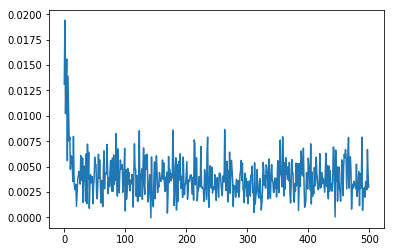

In [130]:
import matplotlib.pyplot as plt

plt.plot(gen_losses)
plt.show()

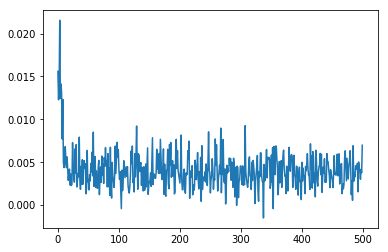

In [131]:
plt.plot(disc_losses)
plt.show()

In [132]:
torch.save(netD_neg.state_dict(), './netD_neg-1m')
torch.save(netG_neg.state_dict(), './netG_neg-1m')

In [133]:
# to test without train
netD_neg_test = NetD(tr.shape[1]).cuda()
netG_neg_test = NetG(tr.shape[1]).cuda()

netD_neg_test.eval()
netG_neg_test.eval()

NetG(
  (netGen): Sequential(
    (0): Linear(in_features=3726, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=3706, bias=True)
    (3): Sigmoid()
  )
)

In [134]:
netD_neg.eval()
netG_neg.eval()

NetG(
  (netGen): Sequential(
    (0): Linear(in_features=3726, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=3706, bias=True)
    (3): Sigmoid()
  )
)

In [135]:
# checking accuraccy
condition = torch.from_numpy(negative_feedback).float().cuda()
noise = torch.randn(condition.shape[0], nz).cuda()
# e_mask = torch.Tensor(to_add_negative).cuda()
e_mask = torch.Tensor(tr > 0).cuda()

concated = torch.cat((noise, condition), 1)
fake_accur_check = netG_neg(e_mask, concated)

In [136]:
# without train
fake_test_accur_check = netG_neg_test(e_mask, concated)

In [137]:
fake_accur_check_ = (fake_accur_check.detach().cpu().numpy() > 0.5).astype(int)

In [138]:
fake_test_accur_check = (fake_test_accur_check.detach().cpu().numpy() > 0.5).astype(int)

In [139]:
(fake_accur_check_ * negative_feedback).sum(), (fake_accur_check_ * positive_feedback).sum()

(230186, 130432)

In [140]:
(fake_test_accur_check * negative_feedback).sum(), (fake_test_accur_check * positive_feedback).sum()

(192938, 260072)

In [141]:
# accuracy on negative items
(fake_accur_check_ * negative_feedback).sum() / negative_feedback.sum()

0.6016880703249365

In [142]:
# accuracy on negative items - WITHOUT TRAIN 
(fake_test_accur_check * negative_feedback).sum() / negative_feedback.sum()

0.504324732661207

In [143]:
# accuracy on positive items
((1-fake_accur_check_) * positive_feedback).sum() / positive_feedback.sum()

0.7480164058258841

In [144]:
# accuracy on positive items - WITHOUT TRAIN 
((1-fake_test_accur_check) * positive_feedback).sum() / positive_feedback.sum()

0.4975628886772368

In [145]:
# accuracy on positive items - WITHOUT TRAIN 
((1-fake_test_accur_check) * positive_feedback).sum() / positive_feedback.sum()

0.4975628886772368

In [146]:
import gc
gc.collect()

7211

In [147]:
del fake_accur_check
del fake_test_accur_check 
del e_mask

In [ ]:
# condition, X, idxs = generator_negative.gen_item_GAN()

# X = torch.from_numpy(X).float().cuda()
# condition = torch.from_numpy(condition).float().cuda()
# # real = Variable(X)

# noise = torch.randn(64, nz).cuda()
# e_mask = torch.Tensor(tr[idxs]>0).cuda()

# concated = torch.cat((noise, condition), 1)
# fake = netG_neg(e_mask, concated)

In [ ]:
# fake_test = netG_neg_test(e_mask, concated)

In [ ]:
# (fake > 0.5).sum(), ((fake > 0.5) * (condition==0)).sum(), condition.sum(), X.sum(), e_mask.sum()

In [ ]:
# fake = (fake >= 0.5).float()

In [ ]:
# fake_test = (fake_test > 0.5).float()

In [ ]:
# (fake * condition).sum()/condition.sum(), (fake * X).sum()/X.sum()

In [ ]:
# (fake * condition).sum()/condition.sum(), (fake * X).sum()/fake.sum()

In [ ]:
# (fake_test * condition).sum()/condition.sum(), (fake_test * X).sum()/X.sum()

In [ ]:
# # accuraccy on zeros (positive feedbacks)
# (fake * (1-condition)*X).sum()/(X * (1 - condition)).sum()

In [ ]:
# (fake_test * (1-condition)*X).sum()/(X * (1 - condition)).sum()

In [ ]:
# # accuraccy on zeros (positive feedbacks)
# ((1 - fake)*(1-condition)*(torch.from_numpy(positive_feedback[idxs]).float().cuda())).cpu().numpy().sum()/((positive_feedback[idxs]).astype(float)*(1-condition).cpu().numpy()).sum()

In [ ]:
# ((1 - fake_test)*(1-condition)*(torch.from_numpy(positive_feedback[idxs]).float().cuda())).cpu().numpy().sum()/((positive_feedback[idxs]).astype(float)*(1-condition).cpu().numpy()).sum()

In [ ]:
# condition, X, idxs = batch_generator(X_neg, y_neg, batch_size=256)
# # predicting on ngetavie feedbacks
# condition = torch.from_numpy(X_neg).float().cuda()
# X = torch.from_numpy(y_neg).cuda()


# noise = torch.randn(condition.shape[0], nz).cuda()
# e_mask = torch.Tensor(tr>0).cuda()

# concated = torch.cat((noise, condition), 1)
# fake = netG_neg(e_mask, concated)

In [ ]:
# fake.shape

In [ ]:
# fake = (fake > 0.4).float()

In [ ]:
# fake = fake.int().cpu().numpy()

In [ ]:
# fake = fake.astype(int)

In [ ]:
# fake.sum(), negative_feedback_mask.sum(), to_add_negative.sum()

In [ ]:
# (fake * negative_feedback_mask).sum()/negative_feedback_mask.sum() #checking negative 

In [ ]:
# (fake * to_add_negative).sum()/to_add_negative.sum() #checking negative 

In [ ]:
# ((1-fake) * positive_feedback_mask).sum()/positive_feedback_mask.sum() #checking positive

In [ ]:
# to_add_negative = to_add_negative.astype(int)

In [ ]:
# get_sparsity(to_add_negative), get_sparsity(y_neg)

In [ ]:
# (y_neg*to_add_negative).sum()

In [148]:
# condition, X, idxs = batch_generator(y_neg, to_add_negative, batch_size=256)
# predicting on ngetavie feedbacks
condition = torch.from_numpy(negative_feedback).float().cuda()
# X = torch.from_numpy(to_add_negative).cuda()


noise = torch.randn(condition.shape[0], nz).cuda()
# e_mask = torch.Tensor(to_add_negative).cuda()
e_mask = torch.Tensor(tr == 0).cuda()

concated = torch.cat((noise, condition), 1)
fake = netG_neg(e_mask, concated)

In [149]:
fake = (fake > 0.9).cpu().numpy()

In [ ]:
fake.sum(), to_add_negative.sum(), (to_add_negative*(tr==0)).sum()

In [ ]:
(fake * to_add_negative ).sum()   # checking accuracy with autoencoder generated values

In [ ]:
# # DELETE
# # condition, X, idxs = batch_generator(y_neg, to_add_negative, batch_size=256)
# # predicting on ngetavie feedbacks
# condition_ = torch.from_numpy(negative_feedback).float().cuda()
# # X = torch.from_numpy(to_add_negative).cuda()


# noise_ = torch.randn(condition.shape[0], nz).cuda()
# e_mask_ = torch.Tensor((tr == 0).astype(float)).cuda()

# concated_ = torch.cat((noise_, condition_), 1)
# fake_ = netG_neg(e_mask_, concated_)

In [ ]:
# augmented_train = tr + fake * to_add_negative * np.random.choice(np.arange(1, 4), tr.shape, p=p_probs_neg) 

In [ ]:
# # checking
# print((positive_feedback * (to_add_negative*fake)).sum()/(to_add_negative*fake).sum()) 
# print((positive_feedback * to_add_negative).sum()/to_add_negative.sum()) 
# print((positive_feedback * fake).sum()/fake.sum()) 

In [168]:
to_augment_negative = to_add_negative*fake

In [169]:
(to_augment_negative *(1-negative_feedback)).sum() #new values

4010

In [170]:
# to_aug = to_augment_negative *(1-negative_feedback_mask)

In [171]:
# to_aug.sum()

In [172]:
import nbimporter 
import matrix_factorization

In [173]:
p_probs = [(tr == 1).sum()/((tr > 0) & (tr < 4)).sum(), (tr == 2).sum()/(((tr > 0) & (tr < 4))).sum(), (tr == 3).sum()/((tr > 0) & (tr < 4)).sum()]
p_probs

[0.13207882540835983, 0.25313474502505445, 0.6147864295665857]

In [ ]:
np.random.choice(np.arange(1, 4), tr.shape, p=p_probs)

In [167]:
to_augment_negative.sum()

NameError: name 'to_augment_negative' is not defined

In [174]:
augmented_train = tr + to_augment_negative * np.random.choice(np.arange(1, 4), tr.shape, p=p_probs)

In [175]:
get_sparsity(tr), get_sparsity(augmented_train)

(4.021525859265269, 4.039440249032355)

In [ ]:
MF_SGD = matrix_factorization.ExplicitMF(tr, 40, learning='sgd', verbose=True)
iter_array = [1, 2, 5, 10, 25, 50, 60, 80]

# iter_array = [10]
# iter_array = [1, 2, 5, 10, 25]
MF_SGD.calculate_learning_curve(iter_array, vr, learning_rate=0.001)

In [ ]:
# MF_SGD_aug = matrix_factorization.ExplicitMF(augmented_train, 40, learning='sgd', verbose=True)
# iter_array = [1, 2, 5, 10, 25, 50, 60, 80]

# # iter_array = [10]
# # iter_array = [1, 2, 5, 10, 25]
# MF_SGD_aug.calculate_learning_curve(iter_array, vr, learning_rate=0.001)

In [176]:
MF_SGD = matrix_factorization.ExplicitMF(augmented_train, 40, learning='sgd', verbose=True)
iter_array = [1, 2, 5, 10, 25, 50, 60, 80]

# iter_array = [10]
# iter_array = [1, 2, 5, 10, 25]
MF_SGD.calculate_learning_curve(iter_array, vr, learning_rate=0.001)

Iteration: 1
Train mse: 1.0054055644765958
Test mse: 1.0074799937156813
Iteration: 2
Train mse: 0.9326729588309529
Test mse: 0.9371270949857945
Iteration: 5
Train mse: 0.863053787676433
Test mse: 0.8712224075071392
Iteration: 10
Train mse: 0.8314646291620809
Test mse: 0.8427646602946745
Iteration: 25
	current iteration: 10
Train mse: 0.8086777896278844
Test mse: 0.8258189313710902
Iteration: 50
	current iteration: 10
	current iteration: 20
Train mse: 0.7567334141442847
Test mse: 0.7945486725462679
Iteration: 60
	current iteration: 10
Train mse: 0.7180278806643992
Test mse: 0.7748495304136693
Iteration: 80
	current iteration: 10
	current iteration: 20
Train mse: 0.6326583864648311
Test mse: 0.7467872145590981


In [177]:
MF_SGD = matrix_factorization.ExplicitMF(tr, 40, learning='sgd', verbose=True)
iter_array = [1, 2, 5, 10, 25, 50, 60, 80]

# iter_array = [10]
# iter_array = [1, 2, 5, 10, 25]
MF_SGD.calculate_learning_curve(iter_array, vr, learning_rate=0.001)

Iteration: 1
Train mse: 1.0082582099738886
Test mse: 1.0097977337604331
Iteration: 2
Train mse: 0.9352860075426364
Test mse: 0.9386757464338958
Iteration: 5
Train mse: 0.8643467507935484
Test mse: 0.8714117810539594
Iteration: 10
Train mse: 0.8321931726441352
Test mse: 0.842914561236109
Iteration: 25
	current iteration: 10
Train mse: 0.809157638151105
Test mse: 0.8259229587679571
Iteration: 50
	current iteration: 10
	current iteration: 20
Train mse: 0.7566791660185568
Test mse: 0.7945160499133725
Iteration: 60
	current iteration: 10
Train mse: 0.7174679561985765
Test mse: 0.7751236816396795
Iteration: 80
	current iteration: 10
	current iteration: 20
Train mse: 0.6322252028820194
Test mse: 0.74880699888832


In [178]:
MF_SGD = matrix_factorization.ExplicitMF(augmented_train, 40, learning='sgd', verbose=True)
# iter_array = [1, 2, 5, 10, 25, 50, 60, 80]

# iter_array = [10]
# iter_array = [1, 2, 5, 10, 25]
MF_SGD.calculate_learning_curve([100], vr, learning_rate=0.001)

Iteration: 100
	current iteration: 10
	current iteration: 20
	current iteration: 30
	current iteration: 40
	current iteration: 50
	current iteration: 60
	current iteration: 70
	current iteration: 80
	current iteration: 90
	current iteration: 100
Train mse: 0.55689833063505
Test mse: 0.7469134432578997


In [179]:
MF_SGD = matrix_factorization.ExplicitMF(tr, 40, learning='sgd', verbose=True)
# iter_array = [1, 2, 5, 10, 25, 50, 60, 80]

# iter_array = [10]
# iter_array = [1, 2, 5, 10, 25]
MF_SGD.calculate_learning_curve([100], vr, learning_rate=0.001)

Iteration: 100
	current iteration: 10
	current iteration: 20
	current iteration: 30
	current iteration: 40
	current iteration: 50
	current iteration: 60
	current iteration: 70
	current iteration: 80
	current iteration: 90
	current iteration: 100
Train mse: 0.5575207270968554
Test mse: 0.7471432503263868


In [ ]:
# condition, X, idxs = batch_generator(y_neg, to_add_negative, batch_size=256)
# predicting on ngetavie feedbacks
condition = torch.from_numpy(negative_feedback).float().cuda()
# X = torch.from_numpy(to_add_negative).cuda()


noise = torch.randn(condition.shape[0], nz).cuda()
# e_mask = torch.Tensor(to_add_negative).cuda()
e_mask = torch.Tensor(tr == 0).cuda()

concated = torch.cat((noise, condition), 1)
fake = netG_neg(e_mask, concated)

In [ ]:
# condition, X, idxs = batch_generator(y_neg, to_add_negative, batch_size=256)
# predicting on ngetavie feedbacks
condition = torch.from_numpy(negative_feedback).float().cuda()
# X = torch.from_numpy(to_add_negative).cuda()


noise = torch.randn(condition.shape[0], nz).cuda()
# e_mask = torch.Tensor(to_add_negative).cuda()
e_mask = torch.Tensor(tr > 0).cuda()

concated = torch.cat((noise, condition), 1)
fake_accur_check = netG_neg(e_mask, concated)

In [ ]:
fake_accur_check_ = (fake_accur_check.detach().cpu().numpy() > 0.95).astype(int)

In [ ]:
(fake_accur_check_ * negative_feedback).sum(), (fake_accur_check_ * positive_feedback).sum()

In [ ]:
(fake_accur_check_ * negative_feedback).sum() / ((fake_accur_check_ * negative_feedback).sum() + (fake_accur_check_ * positive_feedback).sum())

In [ ]:
(fake > 0.9).sum()

In [ ]:
fake = (fake > 0.9).float()

In [ ]:
fake = fake.detach().cpu().numpy()

In [153]:
fake = fake.astype(float)

In [154]:
(fake*(tr>0)).sum() # should be zero

0.0

In [160]:
fake = fake.astype(int)

In [161]:
augmented_train_only_gan = tr + fake * np.random.choice(np.arange(1, 4), tr.shape, p=p_probs)

In [163]:
get_sparsity(augmented_train_only_gan), get_sparsity(tr)

(4.3281567745878355, 4.021525859265269)

In [166]:
MF_SGD = matrix_factorization.ExplicitMF(augmented_train_only_gan, 40, learning='sgd', verbose=True)
iter_array = [1, 2, 5, 10, 25, 50, 60, 80]

# iter_array = [10]
# iter_array = [1, 2, 5, 10, 25]
MF_SGD.calculate_learning_curve(iter_array, vr, learning_rate=0.001)

Iteration: 1
Train mse: 0.9643356591125679
Test mse: 0.9850378723821315
Iteration: 2
Train mse: 0.8972174387773421
Test mse: 0.9234190988918609
Iteration: 5
Train mse: 0.8436268874891254
Test mse: 0.8696809850570631
Iteration: 10
Train mse: 0.8187371017454731
Test mse: 0.8453382532264735
Iteration: 25
	current iteration: 10
Train mse: 0.7993064678519609
Test mse: 0.8297496314734026
Iteration: 50
	current iteration: 10
	current iteration: 20
Train mse: 0.7502206107099286
Test mse: 0.8000756978954462
Iteration: 60
	current iteration: 10
Train mse: 0.7134464984377021
Test mse: 0.7819751921442637
Iteration: 80
	current iteration: 10
	current iteration: 20
Train mse: 0.6289449955486643
Test mse: 0.7565968759774923
